# SLU06 - Dealing with Data Problems

## 1. Introduction to data cleanup

In a real world scenario, **data is almost never ready** for exploratory analysis, visualization, or modeling. The world is messy and so is its data. Data problems arise from issues in data collection and data entry, and it's not always possible to correct all of these issues.

Cleaning messy data often ends up consuming the majority of the data scientist's time. On average, 80 percent of time is spent ensuring that your data is in a clean and workable form, while just 20 percent is dedicated to visualizing and analyzing data, creating machine learning models, or other advanced analytics. **Data cleaning is always the first step** when building a machine learning model. 

Although time consuming, data cleaning saves costs down the line. Ideally, thinking about clean data should start when planning the data collection, but unfortunately the data scientist usually has no influence on this step. According to the 1-10-100 principle, the cost of correcting bad data is 10 times more than the cost of preventing bad data, and the cost of fixing a problem generated by bad data is 100 times more.

***No models create meaningful results with messy data - garbage in, garbage out.***

<img src="media/clean-you-must.jpg"/>

### 1.1 Clean data

Clean data is

- **Tidy**: data correctly structured in tables
- **Valid**: values make sense and have the correct datatype and range, e.g., the age of a person is numerical and between 0 and 130 years
- **Accurate**: values correspond to reality, e.g., the customer address is correct
- **Complete**: there are no missing values
- **Consistent**: data does not include contradictory entries, e.g., children are younger than parents
- **Uniform**: units across the dataset are the same, e.g., all distances are expressed in km

**Data cleaning** aims to achieve the above criteria and additionally correct syntax errors, eliminate and duplicate entries, scale and normalize numerical data, and deal with outliers. In this notebook, you'll learn about the techniques necessary to achieve some of these goals. Nonetheless, depending on the nature of the data, it's not always possible to achieve them all. At the same time, this is an **opportunity to really get to know your dataset and document it**. You'll have a chance to learn more about data cleaning in SLU12 and S02. 

Roll up your sleeves, 'cause things are about to get messy...

In [1]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(4,4)

## 2. Tidy data

The **structure** of a tidy dataset is related to its **meaning**:
- Each **variable** is a _column_.
- Each  **observation** is a _row_.
- Each **cell** is a _single measurement_.
- Each **type of observational unit** should be stored in its own _table_.

<img src="media/tidy-data.png"/>

Let's take a minute to think about these concepts. In data science, constructing a **model** means finding a **relationship** between a number of **variables** and an **outcome** (which also happens to be a variable from the point of view of tidy datasets). Each column of a tidy dataset consists of values measured for the same variable (height) across multiple units (people). Each row consists of values measured on the same unit (person) across multiple attributes (height, age, ...). In some cases, it's completely obvious what are the variables; in others, identifying them requires some deliberation. 

A simple **example of a model** could reflect the relationship between an apartment's price on the number of its rooms, its area, and its location. In this example, the **variables** are the number of rooms, the area, and the location. The **outcome** is the price. To deal with this dataset efficiently, it should be stored in a **table** (represented by a pandas dataframe) with **four columns**, one for each of the **three variables** and one for the **outcome**. **Each row** of the dataframe should contain the values of all variables and the outcome for one **observation** (one apartment).

One advantage of tidy datasets is that the **values for different observations and variables can be accessed in the same way** by using the columns/rows of dataframes. Tidy datasets are also easy to manipulate, model, and visualize using **tidy tools**, which are functions and methods that expect tidy inputs and produce tidy outputs, like many of those in pandas.

<img src="media/exploits_of_a_mom.png" />

Unsurprisingly, datasets that are **not tidy** are **messy**, and the **most common problems of messy datasets** are the following:

1) Column headers are values, not variable names.
2) Multiple variables are stored in one column.
3) Variables are stored in both rows and columns.
4) Multiple types of observational units are stored in the same table.
5) A single observational unit is stored in multiple tables.

These problems are solved by through **melting, unstacking, string splitting, and table splitting and joining**. In this notebook, we'll employ melting and string splitting to solve problems 1) and 4). The exercise notebook has an example of problems 2) and 5). Table splitting and joining will be covered in BLU02. 

### 2.1 Problem: Column headers are values, not variable names

In the dataset below, we have two variables: `religion` and `income`.
The tidy data criterion is not fulfilled because **the `income` variable is represented in multiple columns, instead of just one**.

In [2]:
df_messy_1 = pd.read_csv(os.path.join('data', 'column_headers_are_values.csv'),
                         sep=' ')
df_messy_1

,religion,<$10k,$10-20k,$20-30k,$30-40k,$40-50k,$50-75k
0,Agnostic,27,34,60,81,76,137
1,Atheist,12,27,37,52,35,70
2,Buddhist,27,21,30,34,33,58
3,Catholic,418,617,732,670,638,1116
4,Don’t know/refused,15,14,15,11,10,35
5,Evangelical Prot,575,869,1064,982,881,1486
6,Hindu,1,9,7,9,11,34
7,Historically Black Prot,228,244,236,238,197,223
8,Jehovah’s Witness,20,27,24,24,21,30
9,Jewish,19,19,25,25,30,95


This kind of arrangement is useful for presentations, but not for analysis. It complicates answering questions like this:

&nbsp;&nbsp;&nbsp;&nbsp;*How many people who are Buddhist earn between \$10k \ and \ \$40k?*

In [3]:
# How many people with the Buddhist religion earn between $10k and $40k? - with messy data
df_messy_1[df_messy_1.religion == 'Buddhist'][['$10-20k', 
                                               '$20-30k', 
                                               '$30-40k'
                                               ]].sum(axis=1).values[0]

np.int64(85)

The above query doesn't answer the question in a clear and intuitive way. It subsets rows to get the right religion, and then it subsets columns to get the right income values, and finally it uses a sum to get its counts.

We can **tidy up this data** using the `melt method`, which is typically called **melting** or **stacking**. Essentially, this method combines the values from the multiple `income` columns into one. Read more about it here: [melt()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html)

In [4]:
# Getting the income values from the column names (for demonstration purposes)
income_values = [x for x in df_messy_1.columns.tolist() if x!='religion']
print(f"Income values stored in the columns:\n{income_values}")

# Using the melt function to 'melt' the income_values into a column
df_tidy_1 = pd.melt(df_messy_1, id_vars=['religion'], value_vars=income_values, 
                    var_name='income', value_name='freq')
df_tidy_1.head(15) #showing the top 15 observations

Income values stored in the columns:
['<$10k', '$10-20k', '$20-30k', '$30-40k', '$40-50k', '$50-75k']


,religion,income,freq
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Don’t know/refused,<$10k,15
5,Evangelical Prot,<$10k,575
6,Hindu,<$10k,1
7,Historically Black Prot,<$10k,228
8,Jehovah’s Witness,<$10k,20
9,Jewish,<$10k,19


> 💡 **Tip:** Now that you've been introduced to `melt()`, let's add a few functional shortcuts to your repertoire.
>
> The `value_vars` parameter specifies which columns you want to turn into rows. If you don't specify any, `melt()` will default to "**all columns not set as `id_vars`**", which means it will turn all columns you didn't specify with `is_vars` into a row. In our case, we only want to keep the `religion` column, so we'll save a bit of time by letting `melt()` convert the rest of the columns into rows without us having to list those other rows in our code. 

In [5]:
df_tidy_1 = pd.melt(df_messy_1, id_vars=['religion'], var_name='income', 
                    value_name='freq')
df_tidy_1.head(15) #showing the top 15 observations

,religion,income,freq
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Don’t know/refused,<$10k,15
5,Evangelical Prot,<$10k,575
6,Hindu,<$10k,1
7,Historically Black Prot,<$10k,228
8,Jehovah’s Witness,<$10k,20
9,Jewish,<$10k,19


Let's look at what happened in the `melt` function in more detail:
- The `id_vars` parameter lists the columns that were variables in the messy dataset, which we'd now like to keep. Another name for them is "colvars". 
- The `value_vars` parameter lists columns that were values, which we now want to transform into values in a new column called `income`, as indicated in the `var_name` parameter in our `melt()` code.
- The values from the `value_vars` columns were concatenated into a new column called `freq`, as indicated in the `value_name` parameter.

After all of this hard work, answering our original question becomes much easier:

In [6]:
# How many people with the Buddhist religion earn between $10k and $40k?
# (with tidy data)
df_tidy_1[(df_tidy_1.religion == 'Buddhist') & 
          (df_tidy_1.income.isin(['$10-20k', '$20-30k', '$30-40k'])
          )].freq.sum()

np.int64(85)

"Much easier" doesn't mean quicker, but rather simpler. Note how this time we only subset rows, which made our query easier to understand. We did the following:
1. Subset the rows with the desired values for `religion` and `income`.
2. Used a sum of the frequencies (`freq`) to get the final value.

Oftentimes, the tidying process increases the time (and code) it takes to get information out of a _DataFrame_, but the ease with which you can extract information from a tidy DataFrame makes your extra work worth it. 

### 2.2 Problem: Multiple types of observational units are stored in the same table

Let's try another messy dataset:

In [7]:
df_messy_2 = pd.read_csv(os.path.join('data', 'multiple_types.csv'))
df_messy_2

,year,artist,track,time,date.entered,wk1,wk2,wk3
0,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,87,82,72
1,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,91,87,92
2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,81,70,68
3,2000,A*Teens,Dancing Queen,3:44,2000-07-08,97,97,96
4,2000,Aaliyah,I Don't Wanna,4:15,2000-01-29,84,62,51
5,2000,Aaliyah,Try Again,4:03,2000-03-18,59,53,38
6,2000,"Adams, Yolanda",Open My Heart,5:30,2000-08-26,76,76,74
7,2000,"Aguilera, Christina",I Turn To You,4:00,2000-04-15,50,39,30


Don't wear yourself out trying to catch the "multiple types of observational units are stored in the same table" messy data problem in this _DataFrame_, because... it isn't there yet! 😛 _Just a little patience_ 🔫🌹. We'll get there soon enough 😉

This is a subset of a music billboard dataset: **each row is a song in the billboard, and the columns have information about the following variables**:
* `year` of the billboard
* `artist`
* `track` name
* `time` or track duration 
* `date.entered`, which is the date the song entered the billboard
* `wk1`, `wk2` and `wk3`: the rank of the song in the weeks after it entered the top 100. Note: We're showing only the first three weeks here. The original dataset goes all the way to week seventy-five.

This dataset isn't tidy, but it's useful for data entry. The ranking of each song is added to the `week columns`, as long as it remains on the billboard.

Start by melting the dataset: **`wk1`, `wk2` and `wk3` columns all refer to the same variable, which is the rank of the song on the billboard in weeks since it entered the top 100**. The `melt()` function will take care of this again.

In [8]:
id_vars = ['year', 'artist', 'track', 'time', 'date.entered']
value_vars = ['wk1', 'wk2', 'wk3']
df_melted = pd.melt(df_messy_2, id_vars=id_vars, value_vars=value_vars, 
                    var_name='week', value_name='position')
df_melted.sort_values(['artist', 'week']).head(10)

,year,artist,track,time,date.entered,week,position
0,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,wk1,87
8,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,wk2,82
16,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,wk3,72
1,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,wk1,91
9,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,wk2,87
17,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,wk3,92
2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk1,81
10,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk2,70
18,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk3,68
3,2000,A*Teens,Dancing Queen,3:44,2000-07-08,wk1,97


We've now created the problem that we wanted to demonstrate in this section **that two observational units exist in the same table**: one is the song itself, and the other is its billboard rank at a certain point in time. As a consequence, song data repeats. The problem with this is that it may lead to inconsistent data if the same information is accidentally modified in different entries.

**We need to split these two types of observational units into two tables**, but we shouldn't loose the connection between the units in the process. We can use a **mapping id** between both tables to keep this connection. Our table doesn't have a unique id, so we'll have to create one. 

Let's go back to the original messy dataset and start tidying up again. First, we'll divide the dataset into a song table and a rank table, and then we'll melt the rank table.

In [9]:
# We create an id for each song, then copy the song data to another table
df_messy_2['song_id'] = range(len(df_messy_2))
df_songs = df_messy_2[['song_id'] + id_vars]
df_songs

,song_id,year,artist,track,time,date.entered
0,0,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26
1,1,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02
2,2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08
3,3,2000,A*Teens,Dancing Queen,3:44,2000-07-08
4,4,2000,Aaliyah,I Don't Wanna,4:15,2000-01-29
5,5,2000,Aaliyah,Try Again,4:03,2000-03-18
6,6,2000,"Adams, Yolanda",Open My Heart,5:30,2000-08-26
7,7,2000,"Aguilera, Christina",I Turn To You,4:00,2000-04-15


In [10]:
# We keep the positions per week and the song_id in another table, then melt the week columns
df_rank = pd.melt(df_messy_2, id_vars=['song_id'], 
                  value_vars=value_vars, 
                  var_name='week', 
                  value_name='position')
df_rank = df_rank.sort_values(['song_id', 'week']).reset_index(drop=True)
df_rank.head()

,song_id,week,position
0,0,wk1,87
1,0,wk2,82
2,0,wk3,72
3,1,wk1,91
4,1,wk2,87


Look at that! Two beautiful **tidy** datasets!

Now that we learned how to tidy up issues with dataset structure, we can focus on problems in dataset values: that is, dealing with datasets' validity, accuracy, completeness, consistency, uniformity, and if there are any missing or duplicated values.

## 3. Data entry problems

<img src="media/monkey.gif"/>

**To err is not only human, but also expected.**  Typical data entry problems are
- Case mismatches and grammar errors in text fields
- Wrong datatypes
- Nonsense values (aka *“I really don’t know what to write here but this form forces me to write something...”*)
- Missing values
- Duplicate observations
- Lack of standardization (like dashes and slashes in phone numbers or `Port.` and `PT` for Portugal)
- Extra white spaces
- Dealing with information irrelevant to the given analysis

Many of these problems can be prevented at data collection by enforcing a certain format or by checking for datatypes and consistency, but, as a data scientist, you don't always have influence on that part of the process. In this section, you'll learn how get an overview of variable values to detect possible problems, and then use string and mathematical operations to correct the problems you find.

The following dataset illustrates some of those problems:

In [11]:
data = pd.read_csv(os.path.join('data', 'data_with_problems.csv'), index_col=0)
print(f"This dataset has {len(data)} observations.")
print("Here are the top 10:")
data.head(10)

This dataset has 203 observations.
Here are the top 10:


,age,height,gender,birthdate
CFLOXRHMDR,88.0,163.0,female,1942-02-27
FXLJSNLSOG,29.0,158.0,female,1946-03-31
FWDIVJKGOI,42.0,159.0,female,1946-09-13
YWEBKQWHRE,25.0,179.0,male,1947-08-25
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
SSZQEGTLNK,NaN,162.0,male,1959-01-22
PRFEFXNGWN,36.0,166.0,female,1962-04-16


Based on the names of the variables (columns), we can assume that each observation (row) represents a person. In this dataset, we have

* 4 variables: **age**, **height**, **gender**, and **birthdate**
    * The gender variable is categorical, and the other three are numerical.
* 203 observations

Let's recall the difference between categorical and numerical variables: 
- **Numerical** variables take values that are numbers. In theory, there is an infinite amount of values from which to choose; in practice, values are often restricted to a certain range.
- **Categorical** variables take a finite set of values, which aren't ordered. Sometimes, categorical values are coded as numbers, but that doesn't guarantee that they'll be ordered. We could code the gender variable values in our data as 0 and 1, for instance, but it doesn't make sense to say that gender 1 is larger than gender 0.

SLU12 will include more information on variable types and how to deal with them when building statistical models.

### 3.1 Data entry problems in categorical variables

Let's look at the categorical variable `gender`. The first step is to get an overview of the values in that variable and detect if it has any problems. Two useful functions for doing this are `numique` ([nunique](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html)), which counts how many different types of unique values we have, and `value counts` ([value_counts](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)), which counts the number of values for each unique type. 

- **nunique()**

In [12]:
data['gender'].nunique()

7

`7`. That's an odd number. Most datasets will have 2-4 (female, male, non-binary, prefer not to tell). What's their breakdown?

- **value_counts()**

In [13]:
data['gender'].value_counts()

gender
female       111
male          67
MALE           9
m              3
F              2
f              1
   female      1
Name: count, dtype: int64

Ok... Most of the observations have gender with either with *female* or *male* values, but there are other variations: `MALE`, `m`, `F`, `f`, &nbsp;&nbsp;&nbsp;`female` (*with leading blank spaces!!*). A clear case of insufficient crosschecking at data entry.

By default, `value_counts` doesn't take into consideration missing data. We can change this by passing the `dropna` attribute as `False`. 

In [14]:
data['gender'].value_counts(dropna=False)

gender
female       111
male          67
NaN            9
MALE           9
m              3
F              2
f              1
   female      1
Name: count, dtype: int64

No missing data here.

### 3.1.1 String operations

To clean this data, we can do **string operations** directly on the dataframe (*much magic! such wow!*).
We can apply **python string methods** to all the elements in a pandas Series by calling `.str` on the Series followed by the string method. The first steps are usually conversion to lowercase or uppercase and white space removal. Then, we may need to filter out or replace characters and split or concatenate strings.

- **str.lower() and str.upper()**

Let's convert all the strings in the `gender` column to lowercase using `str.lower` ([str.lower](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.lower.html)).

In [15]:
data['gender'] = data['gender'].str.lower()
data['gender'].value_counts()

gender
female       111
male          76
f              3
m              3
   female      1
Name: count, dtype: int64

As we can see, this converted all the cases of uppercase `MALE` (which were 9) to lowercase `male` (before: 67 observations; after: 76 observations). Also, all the cases of uppercase `F` (which were 2) were converted to `f` (before: 1 observation; after: 3 observations).

`str.upper` ([str.upper](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.upper.html)) does exactly the opposite. It converts the strings to uppercase.

In [16]:
data['gender'].str.upper().value_counts()

gender
FEMALE       111
MALE          76
F              3
M              3
   FEMALE      1
Name: count, dtype: int64

- ##### str.strip()

Another useful method is `str.strip` ([str.strip](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.strip.html)), which removes leading and trailing whitespaces from strings. Let's try it out:

In [17]:
data['gender'] = data['gender'].str.strip()
data['gender'].value_counts()

gender
female    112
male       76
f           3
m           3
Name: count, dtype: int64

The string "&nbsp;&nbsp;&nbsp;`female`", with leading whitespaces, was converted to "`female`" without whitespaces. Yay! 

- **str.replace()**

Next, we need to replace `m` with `male` and `f` with `female`. We can do that using the `str.replace` method -- read about that here: [str.replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html) -- which receives a **pattern** and a **replacement** string as arguments. The pattern can be a regular expression ([regex](https://www.debuggex.com/cheatsheet/regex/python)).

In [18]:
# Note that here we're not changing the values in data.gender, we're 
# just outputting them!
data['gender'].str.replace('m', 'male').value_counts()

gender
femaleale    112
maleale       76
f              3
male           3
Name: count, dtype: int64

Wait... something went wrong!

`str.replace()` replaces **all** occurrences of the pattern in the Series values, even if they appear in the middle of something. We can fix this in two ways.

**First option**: using **regex** to specify that we want to replace the string `m` with `male`, but only when it appears alone. Don't forget that in **regex** `^` and `$` mean beginning and end of string, respectively.

In [19]:
data['gender'].str.replace('^m$', 'male', regex=True).value_counts()

gender
female    112
male       79
f           3
Name: count, dtype: int64

We can chain replacement operations together in order to handle the `m` and `f` replacements at the same time.
Notice that we need to call `.str` for each operation.

In [20]:
(data['gender'].str.replace('^m$', 'male', regex=True)
    .str.replace('^f$', 'female', regex=True).value_counts())

gender
female    115
male       79
Name: count, dtype: int64

**Second option**: instead of using the `str.replace` method, we can use the pandas `replace()` method, which receives a **dictionary** as an argument. Note how the dictionary includes the full-word replacements (female and male) we want to make with our strings.

In [21]:
data['gender'] = data['gender'].replace({'m': 'male', 'f': 'female'}) # this time the changes are being saved!
data['gender'].value_counts()

gender
female    115
male       79
Name: count, dtype: int64

Looking good!

- **str.split() and str.cat()**

So far, we've seen how to use some string methods directly on Series. There are many more string methods available, but we'll limit ourselves to just  two more, str.cat and str.split, and use them on the birthdate column.

We can use the `str.split()` ([str.split()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html)) method to split the birthdate into three variables, **year**, **month** and **day**, which is a practical approach for our data manipulation needs here.

In [22]:
dates = data.birthdate.str.split(pat='-', expand=True)  # the pat argument receives the string
dates.columns = ['year', 'month', 'day']                # where the split is made.
dates.head()                                            # expand means the split happens at all occurences of pat

,year,month,day
CFLOXRHMDR,1942,02,27
FXLJSNLSOG,1946,03,31
FWDIVJKGOI,1946,09,13
YWEBKQWHRE,1947,08,25
YPUQAPSOYJ,1954,01,24


And just for fun, we can merge our data back together with a different separator using `str.cat()` ([str.cat()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.cat.html)):

In [23]:
dates['month_year'] = dates.month.str.cat(dates.year, sep='/')
dates.head()

,year,month,day,month_year
CFLOXRHMDR,1942,02,27,02/1942
FXLJSNLSOG,1946,03,31,03/1946
FWDIVJKGOI,1946,09,13,09/1946
YWEBKQWHRE,1947,08,25,08/1947
YPUQAPSOYJ,1954,01,24,01/1954


### 3.2 Data entry problems in numerical variables

Data entry problems can also happen in **numerical variables**. Let's go back to our dataframe and look closely at the feature `age`. We can use the `describe()` method from SLU01 to look at the age distribution:

In [24]:
data[['age']].describe()

,age
count,1.940000e+02
mean,1.546424e+06
std,2.153874e+07
min,1.000000e+00
25%,2.100000e+01
50%,2.700000e+01
75%,3.600000e+01
max,3.000000e+08


It seems that the oldest person in our dataset is 300 millions years old, about 100 times older than humankind! Using the [oldest person ever in the Guinness world records](https://www.guinnessworldrecords.com/world-records/oldest-person) as a baseline, let's set the maximum possible age to 123 and the lowest to 0 and see how many values are out of range:

In [25]:
data['age'][(data['age'] < 0) | (data['age'] > 123)]

TSHRBGFOJU    300000000.0
SQYVEHAWSW          224.0
Name: age, dtype: float64

Let's handle these values as if they're missing values and replace them with `np.nan`. 

In [26]:
data.loc[(data['age'] < 0) | (data['age'] > 123), "age"] = np.nan
data.loc[["TSHRBGFOJU", "SQYVEHAWSW"]]

,age,height,gender,birthdate
TSHRBGFOJU,NaN,184.0,female,1947-07-05
SQYVEHAWSW,NaN,166.0,male,1976-01-22


We'll explain how to deal with missing values in section 4.

### 3.3 Applying functions to columns and rows

Using `.str` functions, we could apply string functions to whole columns. What if we wanted to apply any other function to a row or column? We can use Pandas `map()` and `apply()` methods to do just that.   

Think of `map()` and `apply()` as so-called syntactic sugar: while they look pretty in code, all they do under the hood is loop through and apply a function to a column or row of values one by one. Both of these methods are therefore very slow, except when using numpy vectorized functions with `apply()`. Let's see some examples.

Imagine that you'd like to calculate the square of the height column. It can be done using `map()` and the numpy `sqrt()` function. Notice that the function is passed without parenthesis.

In [27]:
data.age.map(np.sqrt)

CFLOXRHMDR    9.380832
FXLJSNLSOG    5.385165
FWDIVJKGOI    6.480741
YWEBKQWHRE    5.000000
YPUQAPSOYJ    5.656854
                ...   
VYAQBLJKXJ         NaN
BLAKTCGBMO    5.656854
ZNLRYQHPXJ    5.000000
XUAJJPLVOI    4.242641
TRMMGYEEPC    4.582576
Name: age, Length: 203, dtype: float64

`map()` operates on pandas Series and outputs a Series. The function can be a predefined function or a lambda function. See more details [here](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html).

`apply()` operates on DataFrames and returns a DataFrame or a Series.

In [28]:
data[['age','height']].apply(np.sqrt)

,age,height
CFLOXRHMDR,9.380832,12.767145
FXLJSNLSOG,5.385165,12.569805
FWDIVJKGOI,6.480741,12.609520
YWEBKQWHRE,5.000000,13.379088
YPUQAPSOYJ,5.656854,13.000000
...,...,...
VYAQBLJKXJ,NaN,12.845233
BLAKTCGBMO,5.656854,13.964240
ZNLRYQHPXJ,5.000000,12.449900
XUAJJPLVOI,4.242641,12.961481


The `axis` argument specifies if the function is applied to columns or rows. Here is an example of summing row values:

In [29]:
data[['age','height']].apply(sum, axis=1)

CFLOXRHMDR    251.0
FXLJSNLSOG    187.0
FWDIVJKGOI    201.0
YWEBKQWHRE    204.0
YPUQAPSOYJ    201.0
              ...  
VYAQBLJKXJ      NaN
BLAKTCGBMO    227.0
ZNLRYQHPXJ    180.0
XUAJJPLVOI    186.0
TRMMGYEEPC    177.0
Length: 203, dtype: float64

You can design any complicated lambda function combining the values from several columns. Here we multiply the `age` column by 2 and then add the square root of `height`:

In [30]:
data[['age','height']].apply(lambda x:x['age']*2+np.sqrt(x['height']),axis=1)

CFLOXRHMDR    188.767145
FXLJSNLSOG     70.569805
FWDIVJKGOI     96.609520
YWEBKQWHRE     63.379088
YPUQAPSOYJ     77.000000
                 ...    
VYAQBLJKXJ           NaN
BLAKTCGBMO     77.964240
ZNLRYQHPXJ     62.449900
XUAJJPLVOI     48.961481
TRMMGYEEPC     54.489996
Length: 203, dtype: float64

Find out more about `apply()` [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html).

### 3.4 Duplicated entries

Dealing with duplicated entries requires two steps:
1. Define what is a duplicate in the context of our problem.
2. Search for duplicated entries and drop them from the dataset.

<img src="media/meme-of-duplicate.jpg"/>

In our case, each row (observation) corresponds to a person, for which we know an ID (in the index), age, height, gender, and birthdate. **Duplicates** are cases where two or more rows are **exact matches**, i.e, **the index and the values in all the columns are the same**.

We can find duplicates using the `duplicated()` method and drop duplicated data with the `drop_duplicates()` method. Learn more about those methods here: [duplicated()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html) and [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html).

In [31]:
# Can you find some duplicates in the 10 first observations?
data.head(10)

,age,height,gender,birthdate
CFLOXRHMDR,88.0,163.0,female,1942-02-27
FXLJSNLSOG,29.0,158.0,female,1946-03-31
FWDIVJKGOI,42.0,159.0,female,1946-09-13
YWEBKQWHRE,25.0,179.0,male,1947-08-25
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
SSZQEGTLNK,NaN,162.0,male,1959-01-22
PRFEFXNGWN,36.0,166.0,female,1962-04-16


In [32]:
duplicated_mask = data.duplicated(keep='first')

print('Number of duplicates:', duplicated_mask.sum())

Number of duplicates: 6


Notice the `keep='first'` in `data.duplicated(...)`. That means that **all the duplicates are flagged as True, except for the first**. For example, there are a total of 4 rows with index `YPUQAPSOYJ`, but only 3 in the duplicated_mask.

Which are the duplicated entries?

In [33]:
data[duplicated_mask]

,age,height,gender,birthdate
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
ZNLRYQHPXJ,25.0,155.0,male,1984-03-13
XUAJJPLVOI,18.0,168.0,female,1996-04-30
TRMMGYEEPC,21.0,156.0,female,1957-03-12


These are the duplicated observations. Each one has **at least** another matching entry in our dataset:

In [34]:
data.loc['ZNLRYQHPXJ']

,age,height,gender,birthdate
ZNLRYQHPXJ,25.0,155.0,male,1984-03-13
ZNLRYQHPXJ,25.0,155.0,male,1984-03-13


How can we drop all duplicates, except for each first occurrence?

In [35]:
print(f"Shape before dropping duplicates: {data.shape}")
data = data.drop_duplicates()
print(f"Shape after dropping duplicates: {data.shape}")

Shape before dropping duplicates: (203, 4)
Shape after dropping duplicates: (197, 4)


That was easy! ;) 

## 4. Missing values

We learned how to fix data that is there, but what if it's just... missing? 

This is probably the biggest data problem we generally face. But worry not! There is a way.

<img src="media/missing-data.jpg" width="300"/>

Dealing with missing data is one of the most tricky, but common, parts of data cleaning. While many models can live with the problems we've been looking at so far, **most models don’t accept missing data**.

### 4.1 How to detect missing values

In order to locate missing values, we can use the method `isnull()`, followed by `sum()`, to count how many missing values we have per column. Learn about those methods here: [isnull()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html) and [sum()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sum.html).

In [36]:
data.isnull().sum()

age          11
height        4
gender        9
birthdate     0
dtype: int64

In [37]:
data.head(10).isnull() # show just the first 10 rows

,age,height,gender,birthdate
CFLOXRHMDR,False,False,False,False
FXLJSNLSOG,False,False,False,False
FWDIVJKGOI,False,False,False,False
YWEBKQWHRE,False,False,False,False
YPUQAPSOYJ,False,False,False,False
SSZQEGTLNK,True,False,False,False
PRFEFXNGWN,False,False,False,False
IIVXDNOAIV,False,False,False,False
VVQYVNRAGQ,False,False,False,False
YVEDWPTEEB,False,False,False,False


So in total we have 24 observations with missing data accross three variables. We can also see this explicitly with missing values indicated with `True`.

The opposite to `isnull()` is `notnull()`, which shows the values that are not missing:

In [38]:
data.head(10).notnull()

,age,height,gender,birthdate
CFLOXRHMDR,True,True,True,True
FXLJSNLSOG,True,True,True,True
FWDIVJKGOI,True,True,True,True
YWEBKQWHRE,True,True,True,True
YPUQAPSOYJ,True,True,True,True
SSZQEGTLNK,False,True,True,True
PRFEFXNGWN,True,True,True,True
IIVXDNOAIV,True,True,True,True
VVQYVNRAGQ,True,True,True,True
YVEDWPTEEB,True,True,True,True


We've seen how many missing values we have in each column. Now, we'd like to see their rows. To answer this question, we will use the python method `any()`. Learn more about it here: [any()](https://docs.python.org/3/library/functions.html#any)

In [39]:
# For each row, we get True if any of the columns is null and False otherwise
mask = data.isnull().any(axis=1)

# Then wee select the rows for which the mask is True
data[mask]

,age,height,gender,birthdate
SSZQEGTLNK,NaN,162.0,male,1959-01-22
CWCFROPRFE,22.0,NaN,male,1978-03-23
TJQPFEFVVH,NaN,182.0,NaN,1990-07-24
PYHWLDVICX,NaN,181.0,female,1955-12-19
MLRPKGKACD,NaN,185.0,male,1997-09-13
TSHRBGFOJU,NaN,184.0,female,1947-07-05
SGMGUJEBNC,NaN,173.0,male,1956-06-08
EORSIPDIHA,21.0,NaN,male,1958-09-26
YZDOYNOXAF,NaN,144.0,female,1968-07-03
QXUGUHCOPT,101.0,196.0,NaN,1970-02-09


With a **small number of features** like we have here, it's possible to visualize missing data via a **heatmap**. Learn about heatmaps, by the way, here: [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

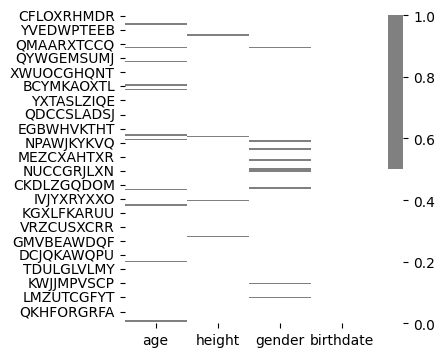

In [40]:
colours = ['#FFFFFF', '#808080'] # specify the colours - white is not missing, gray is missing.
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours));

An alternative to the heatmap is a **missing data histogram**, which is a better option for data with many features. Its code is a more complex, but it allows you to plot only variables with missing data, and it shows the number of missing values per row.

created missing indicator for: age
created missing indicator for: height
created missing indicator for: gender


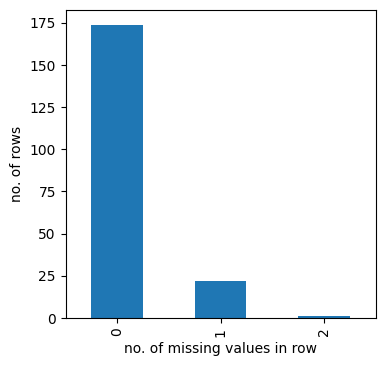

In [41]:
# first, for each column with missing data, create a new column indicating the missing values
missing_data=pd.DataFrame()
for col in data.columns:
    missing = data[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        missing_data['{}_ismissing'.format(col)] = missing
    missing_data.set_index(data.index)

# then, sum the missing values for each row
# and plot the histogram of missing values per row
ismissing_cols = [col for col in missing_data.columns if 'ismissing' in col]
missing_data['num_missing'] = missing_data[ismissing_cols].sum(axis=1)
missing_data['num_missing'].value_counts().sort_index().plot.bar(
    x='num_missing', y='count', xlabel='no. of missing values in row', 
    ylabel='no. of rows', legend=False);

### 4.2 Handling missing values

Dealing with missing data is not straightforward. It depends on the amount of missing data, the reasons why it's missing, and the judgement of the data scientist. Data can be missing for two reasons: (1) it wasn't recorded (failure in data collection) or (2) it doesn't exist (e.g. missing driving license number for children). Ultimately, your best option is to exclude non-existent data from your analysis. You basically have three strategies: 
- **Drop**: the best stratedy for large amounts of missing values 
- **Impute**: fill in values based on known values, which makes sense for smaller amounts of missing data
- **Flag**: uses a new variable to indicate values as missing

### 4.2.1 Drop missing values

The simplest way to handle missing values is to discard rows with them. It's the preferred option when we have large amounts of missing values. We can do it using the `dropna()` method (learn about that here: [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)), which drops all the rows with missing values from a DataFrame.

In [42]:
print(f"Shape before dropping missing values: {data.shape}")
data_no_missing_values = data.dropna()
print(f"Shape after dropping missing values: {data_no_missing_values.shape}")

Shape before dropping missing values: (197, 4)
Shape after dropping missing values: (174, 4)


If there are too many missing values in a column, consider removing that variable from the analysis altogether.

### 4.2.2 Impute missing values for numerical variables

An alternative to dropping rows is imputation, which replaces them with new values. There are different ways to do this depending on if the variables are numerical or categorical.

For **numerical variables**, you can choose to replace them with either a **mean** or **median**. The **mean** approach replaces missing values with the value that's most frequent in the values that aren't missing. The **median** approach also replaces missing values with a mean (the most frequent among remaining values), but it's less sensitive to outliers and works for asymmetrical data, which makes it a safer choice than the mean.

To see variable distributions, use plots such as boxplots or histograms, statistical tools to check for normal distribution, or descriptive statistics such as frequency tables, as we saw in SLU01, SLU03, and SLU04. For example, here's the distribution for the variable age:

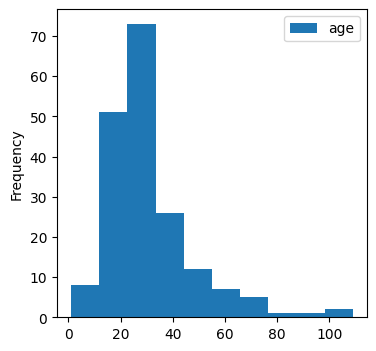

In [43]:
data['age'].plot.hist(legend=True);

We will use the method `fillna()` to fill in the median. Learn more about that method here: [`fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [44]:
print(f"Missing values in the age column before: {data.age.isnull().sum()}")
age_without_missing_values = data.age.fillna(data.age.median())
print(f"Missing values in the age column after: {age_without_missing_values.isnull().sum()}")

Missing values in the age column before: 11
Missing values in the age column after: 0


Pro tip: you can replace missing values for several variables using a dictionary:

In [45]:
data = data.fillna({
    'age': data.age.median(),
    'height': data.height.median()
})

Sometimes, you a smarter approach with imputation uses the mean or median of a cluster or grouping of similar observations instead of the entire population. For example, if you have missing values in the `height` feature, it might make more sense to replace them according to the `gender` of each observation. Another more sofisticated imputation for normal distributions is filling in with randomly generated data from the interval `\[mean-std , mean+std\]`.

### 4.2.3 Replace outliers

Outliers can be treated in the same way as missing data. In normal distributions, outliers are values more than 1.5 interquartile range away from the first or third quartile. Outlier removal shouldn't be done automatically and should be based on sound reasoning. Otherwise, you might miss something important, such as the formation of a [hole in the ozone layer](https://www.math.uni-augsburg.de/htdocs/emeriti/pukelsheim/1990c.pdf). Some statistical models are more sensitive to outliers, for instance, linear regression, in which case you should take your time to understand how to use them properly or rely on more robust methods.

### 4.2.4 Impute missing values for categorical variables

For **categorical variables**, we use replacement strategies similar to what we use for numerical variables. We can fill in a random value, the value from the next row, or even sort rows by another variable beforehand. We can also use the most common value from a cluster of similar observations.

Let's replace the missing values in the `gender` column with the previous valid value. We'll use the `fillna()` method again and set the argument `method` to `backfill`:

In [46]:
print("Missing values in the gender column before: "
      f"{data.gender.isnull().sum()}")
gender_without_missing_values = data.gender.fillna(method='backfill')
print("Missing values in the age column after: "
      f"{gender_without_missing_values.isnull().sum()}")

Missing values in the gender column before: 9
Missing values in the age column after: 0


In [47]:
data.gender.value_counts(), gender_without_missing_values.value_counts()

(gender
 female    113
 male       75
 Name: count, dtype: int64,
 gender
 female    118
 male       79
 Name: count, dtype: int64)

Both values increased by a similar amount, as if we filled them in randomly.

### 4.2.5 Flag missing values

In principle, the fact that some values are missing is useful information, which we will loose if we fill them in. A solution is to flag missing values. For numerical variables, we can use a placeholder number, like 0, to fill in missing values, and then we can create a new variable to flag what's missing. The process is similar for categorical variables, except that we will fill our new category with a non-numeric value, like `missing`. 

The benefit from following these strategies is we'll stop pandas from tricking us with **its default of ignoring missing values**.  :)

Let's flag the missing values in the `gender` column:

In [48]:
data.gender=data.gender.fillna('unknown')
data.gender.value_counts()

gender
female     113
male        75
unknown      9
Name: count, dtype: int64

That was a lot of cleaning and tidying up! Now it's time for you to get your hands dirty in the **Exercise Notebook**.

Good luck, and remember:

> *Happy datasets are all alike; every unhappy dataset is unhappy in its own way.*

(Shamelessly adapted from [Tolstoy's Anna Karenina](https://en.wikipedia.org/wiki/Anna_Karenina_principle).)

<img src="media/cleaning.gif"/>

### 5. Further reading

[Hadley Wickham: Tidy data](https://vita.had.co.nz/papers/tidy-data.pdf) and the corresponding [GitHub repo](https://github.com/hadley/tidy-data) with data

[Worldbank data cleaning checklist](https://dimewiki.worldbank.org/Checklist:_Data_Cleaning) and the referenced [GitHub checklist repo](https://github.com/worldbank/DIMEwiki/tree/master/Topics/Checklists)